## Fitting flux points to a spectral model

This notebooks has been inspired from the content found in [Flux point fitting in Gammapy](https://docs.gammapy.org/dev/notebooks/sed_fitting_gammacat_fermi.html)

More info about spectral models may be found in [Spectrum simulation for CTA](https://docs.gammapy.org/dev/notebooks/spectrum_simulation.html#)

In [1]:
from astropy.table import Table
from astropy import units

from gammapy.spectrum import FluxPointsDataset, FluxPoints
from gammapy.modeling import Fit

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
opts = {
   'format': 'ascii',
   'names': ['e_ref', 'e2_flux'], 
}

t = Table.read('../datasets/spectra_CIRELLI11_EW_GAMMA_m2000.txt', **opts)

# Let's add some units
t['e_ref'].unit, t['e2_flux'].unit = "MeV", "cm-2 s-1 MeV"

In [3]:
t

e_ref,e2_flux
MeV,MeV / (cm2 s)
float64,float64
1000.0,3.61e-12
1089.8,3.95e-12
1187.8,4.33e-12
1294.5,4.73e-12
1410.8,5.16e-12
1537.5,5.62e-12
1675.6,6.11e-12
1826.2,6.64e-12


In [4]:
t['dnde'] = t['e2_flux']/(t['e_ref']*t['e_ref'])
t['dnde'].unit = "cm-2 s-1 MeV-1"
t['dnde_err'] = 1e-25
t['dnde_err'].unit = "cm-2 s-1 MeV-1"
#t['dnde_errp'] = 1e-18
#t['dnde_errp'].unit = "cm-2 s-1 MeV-1"

In [5]:
t

e_ref,e2_flux,dnde,dnde_err
MeV,MeV / (cm2 s),1 / (cm2 MeV s),1 / (cm2 MeV s)
float64,float64,float64,float64
1000.0,3.61e-12,3.61e-18,1e-25
1089.8,3.95e-12,3.3258563591771293e-18,1e-25
1187.8,4.33e-12,3.069030853357e-18,1e-25
1294.5,4.73e-12,2.822650005870575e-18,1e-25
1410.8,5.16e-12,2.5925002063951716e-18,1e-25
1537.5,5.62e-12,2.3774208473792054e-18,1e-25
1675.6,6.11e-12,2.176208523032706e-18,1e-25
1826.2,6.64e-12,1.9910006530602083e-18,1e-25


In [6]:
mask = t['dnde']>1e-30
t = t[mask]

In [7]:
#t.remove_column('e2_flux')

In [8]:
t.meta['SED_TYPE'] = 'dnde'
flux_points = FluxPoints(t)

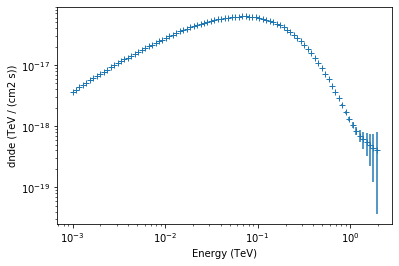

In [9]:
ax = flux_points.plot(energy_power=2)

In [10]:
from gammapy.modeling.models import ExponentialCutoffPowerLaw, SpectralModel

In [11]:
ecpl = ExponentialCutoffPowerLaw(
    index=9.678e-01,
    amplitude="4.729e-15 cm-2 s-1 TeV-1",
    reference="1 TeV",
    lambda_="2.2e+01 TeV-1",
)

In [12]:
dataset_ecpl = FluxPointsDataset(ecpl, flux_points)
fitter = Fit(dataset_ecpl)

In [13]:
result_ecpl = fitter.run()
print(result_ecpl)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 119
	total stat : 803339707768.92



In [14]:
print(ecpl)

ExponentialCutoffPowerLaw

Parameters: 

	   name     value   error      unit      min max frozen
	--------- --------- ----- -------------- --- --- ------
	    index 9.678e-01   nan                nan nan  False
	amplitude 4.729e-15   nan cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00   nan            TeV nan nan   True
	  lambda_ 3.762e+01   nan          TeV-1 nan nan  False


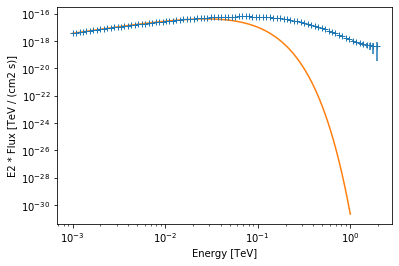

In [15]:
ax = flux_points.plot(energy_power=2)
ecpl.plot(energy_range=[1e-3, 1] * units.TeV, ax=ax, energy_power=2)

Well, this does not seem to fit as we would like :(

We should have to choose a model among the following list:

In [16]:
SpectralModel.__subclasses__()

[gammapy.modeling.models.spectral.ConstantModel,
 gammapy.modeling.models.spectral.CompoundSpectralModel,
 gammapy.modeling.models.spectral.PowerLaw,
 gammapy.modeling.models.spectral.PowerLaw2,
 gammapy.modeling.models.spectral.ExponentialCutoffPowerLaw,
 gammapy.modeling.models.spectral.ExponentialCutoffPowerLaw3FGL,
 gammapy.modeling.models.spectral.PLSuperExpCutoff3FGL,
 gammapy.modeling.models.spectral.PLSuperExpCutoff4FGL,
 gammapy.modeling.models.spectral.LogParabola,
 gammapy.modeling.models.spectral.TableModel,
 gammapy.modeling.models.spectral.ScaleModel,
 gammapy.modeling.models.spectral.AbsorbedSpectralModel,
 gammapy.modeling.models.spectral.NaimaModel,
 gammapy.modeling.models.spectral.SpectralGaussian,
 gammapy.modeling.models.spectral.SpectralLogGaussian,
 gammapy.modeling.models.spectral_crab.MeyerCrabModel]

## User defined model

**Another option would be to define our model as it is described in [Spectrum simulation tutorial](https://docs.gammapy.org/dev/notebooks/spectrum_simulation.html#Adding-a-user-defined-model)**